In [1]:
import sys
import scipy.io
import scipy.signal as sig
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import os

import DataHandlers.SAFERDataset as SAFERDataset
import DataHandlers.CinCDataset as CinCDataset

### Load the CinC training dataset

In [ ]:
dataset = CinCDataset.load_cinc_dataset()

### Load the SAFER dataset

In [ ]:
pt_dataset, dataset = SAFERDataset.load_feas_dataset(feas=2, force_reload=False, process=True, force_reprocess=True)

### Initialise the model

In [5]:
import torch.nn as nn
import torch

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [7]:
if torch.cuda.is_available():
    print("Using Cuda")
    device = torch.device("cuda")
else:
    print("Using CPU")
    device = torch.device("cpu")

Using Cuda


In [39]:
# Compute spectrograms
ecg_tensor = torch.tensor(dataset["data"])
fs = 300
n_fft = 256

ecg_stfts = torch.stft(ecg_tensor, n_fft=n_fft, return_complex=True)
print(ecg_stfts.shape)
freq_axis = np.linspace(0, fs/2, int(round(n_fft/2)))
low_cut = np.argmin(np.abs(freq_axis - 2))
high_cut = np.argmin(np.abs(freq_axis - 50))

print(low_cut, high_cut)

dataset["stft"] = pd.Series([torch.log(torch.abs(stft[low_cut:high_cut])).cpu().numpy() for stft in ecg_stfts], index=dataset.index)

freq_axis = np.linspace(0, fs/2, int(round(n_fft/2)))[low_cut:high_cut]

torch.Size([23259, 129, 141])
2 42


In [41]:
# Normalise spectrograms

dataset["stft"] = dataset["stft"].map(lambda x: (x - x.mean()) / x.std())

In [38]:
# delete variables to save ram
del ecg_stfts

In [ ]:
# Delete old stfts before recomputing
dataset = dataset.drop("stft", axis=1)

In [40]:
ind = 10

fig = go.Figure()
fig.add_trace(go.Heatmap(z=dataset["stft"][0], y=freq_axis))
fig.show()

fig2 = go.Figure()
fig2.add_trace(go.Scatter(y=ecg_tensor[ind].cpu().numpy()))
fig2.show()

In [43]:
print(dataset["stft"][0].shape)

(40, 141)


In [75]:
# Now define a model

class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        self.conv_section1 = nn.Sequential(
            nn.Conv2d(1, 32, 3),
            nn.ReLU(),
            # nn.MaxPool2d(2),
            nn.BatchNorm2d(32)
        )

        self.conv_section2 = nn.Sequential(
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(64)
        )

        self.conv_section3 = nn.Sequential(
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(128)
        )

        self.conv_section4 = nn.Sequential(
            nn.Conv2d(128, 64, 3),
            nn.ReLU(),
            # nn.MaxPool2d(2),
            nn.BatchNorm2d(64)
        )

        self.conv_section5 = nn.Sequential(
            nn.Conv2d(64, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(32)
        )

        self.lstm_n_hidden = 32
        self.lstm = nn.LSTM(input_size=32, hidden_size=32, bidirectional=True, batch_first=True)

        # self.dense1 = nn.Linear(352, 128)
        self.dense2 = nn.Linear(896, 256)
        self.dense3 = nn.Linear(256, 1)

        self.activation = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=-1)

        self.dropout = nn.Dropout()

    def init_lstm_hidden(self, batch_size, device):
        # This resets the LSTM hidden state after each batch
        hidden_state = torch.zeros(2, batch_size, self.lstm_n_hidden, device=device)
        cell_state = torch.zeros(2, batch_size, self.lstm_n_hidden, device=device)
        return (hidden_state, cell_state)

    def forward(self, x):

        # [batch, 1, 40, 141]
        x = self.conv_section1(x)

        # [batch, 32, 38, 139]
        x = self.conv_section2(x)

        # [batch, 64, 18, 68]
        x = self.conv_section3(x)

        # [batch, 128, 7, 32]
        x = self.conv_section4(x)

        # [batch, 64, 5, 30]
        x = self.conv_section5(x)

        # [batch, 32, 1, 14]
        x = x[:, :, 0, :]
        x = torch.transpose(x, 1, 2)

        x, _ = self.lstm(x, self.init_lstm_hidden(x.shape[0], x.device))
        x = torch.flatten(x, 1, -1)

        # [batch, 896]
        x = self.dense2(x)
        x = self.activation(x)
        x = self.dropout(x)

        # [batch, 256]
        x = self.dense3(x)
        # x = self.logsoftmax(x)

        # [4]
        return x

In [72]:
# Onehot encoding
from torch.utils.data import Dataset, DataLoader

def generate_onehot(c):
    if c == "N":
        return np.array([1, 0, 0, 0])
    if c == "O":
        return np.array([0, 1, 0, 0])
    if c == "A":
        return np.array([0, 0, 1, 0])
    if c == "~":
        return np.array([0, 0, 0, 1])

def generate_index(c):
    if c == "N":
        return 0
    if c == "O":
        return 0
    if c == "A":
        return 0
    if c == "~":
        return 1

class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, dataset):
        'Initialization'
        self.dataset = dataset

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.dataset.index)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.dataset.iloc[index]

        X = row["stft"]
        y = row["class_index"]

        return X, y

In [11]:
# dataset["onehot"] = dataset["class"].map(generate_onehot)
dataset["class_index"] = dataset["class"].map(generate_index)

In [55]:
# For CinC Data
train_dataset, test_dataset = train_test_split(dataset, test_size=0.15, stratify=dataset["class_index"])

torch_dataset_train = Dataset(train_dataset)
torch_dataset_test = Dataset(test_dataset)

train_dataloader = DataLoader(torch_dataset_train, batch_size=32, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(torch_dataset_test, batch_size=32, shuffle=True, pin_memory=True)

num_batches = len(train_dataloader)
num_test_batches = len(test_dataloader)
class_counts = torch.tensor(dataset["class_index"].value_counts().values.astype(np.float32))

NameError: name 'dataset' is not defined

In [84]:
# Reset to SAFER balanced data
dataset = feas2_ecg_data_unbalanced

In [68]:
# For SAFER data
# print(feas2_ecg_data.head())

# dataset["onehot"] = dataset["class"].map(generate_onehot)
# Balance the data (for testing only)

"""
feas2_ecg_data_unbalanced = feas2_ecg_data.copy()
feas2_ecg_data_non_noisy = feas2_ecg_data[feas2_ecg_data["measDiag"] != DiagEnum.PoorQuality].sample(1000)
feas2_ecg_data = pd.concat([feas2_ecg_data[feas2_ecg_data["measDiag"] == DiagEnum.PoorQuality], feas2_ecg_data_non_noisy])
"""
train_patients, test_patients = train_test_split(pt_dataset, test_size=0.15)

train_ecgs = dataset[dataset["ptID"].isin(train_patients['ptID'])]
test_ecgs = dataset[dataset["ptID"].isin(test_patients['ptID'])]

print(train_ecgs["class_index"].value_counts())
print(test_ecgs["class_index"].value_counts())

torch_dataset_train = Dataset(train_ecgs)
torch_dataset_test = Dataset(test_ecgs)

train_dataloader = DataLoader(torch_dataset_train, batch_size=32, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(torch_dataset_test, batch_size=32, shuffle=True, pin_memory=True)

num_batches = len(train_dataloader)
num_test_batches = len(test_dataloader)
class_counts = torch.tensor(train_ecgs["class_index"].value_counts().values.astype(np.float32))

0    19504
1      404
Name: class_index, dtype: int64
0    3290
1      61
Name: class_index, dtype: int64


### Train the model

In [76]:
num_epochs = 10
model = CNN().to(device)

# Use weightings to handle class imbalance

class_weights = (class_counts[1] + class_counts[0])/class_counts[1]
loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

In [77]:
import copy
model = model.to(device)

def train(model):
    best_test_loss = 100
    best_model = copy.deepcopy(model).cpu()

    for epoch in range(num_epochs):
        total_loss = 0
        print(f"starting epoch {epoch} ...")
        # Train
        model.train()
        for i, (signals, labels) in enumerate(train_dataloader):
            signals = torch.unsqueeze(signals.to(device), 1).float()
            # fft = torch.abs(torch.fft.fft(signals))
            # signals = torch.cat([signals, fft], dim=1)
            labels = labels.float()

            optimizer.zero_grad()
            output = model(signals).to("cpu")[:, 0]
            loss = loss_func(output, labels)
            loss.backward()
            optimizer.step()
            total_loss += float(loss)

        print(f"Epoch {epoch} finished with average loss {total_loss/num_batches}")
        print("Testing ...")
        # Test
        test_loss = 0
        with torch.no_grad():
            model.eval()
            for i, (signals, labels) in enumerate(test_dataloader):
                signals = torch.unsqueeze(signals.to(device), 1).float()
                # fft = torch.abs(torch.fft.fft(signals))
                # signals = torch.cat([signals, fft], dim=1)
                labels = labels.float()
                output = model(signals).to("cpu")[:, 0]
                loss = loss_func(output, labels)
                test_loss += float(loss)

        print(f"Average test loss: {test_loss/num_test_batches}")

        if test_loss/num_test_batches < best_test_loss:
            best_model = copy.deepcopy(model).cpu()
            best_test_loss = test_loss/num_test_batches

    return best_model

model = train(model).to(device)

starting epoch 0 ...
Epoch 0 finished with average loss 1.1903199328656755
Testing ...
Average test loss: 1.0687676446778434
starting epoch 1 ...
Epoch 1 finished with average loss 0.8479486774192767
Testing ...
Average test loss: 0.9344292493093581
starting epoch 2 ...
Epoch 2 finished with average loss 0.702346847968155
Testing ...
Average test loss: 0.7929532590366545
starting epoch 3 ...
Epoch 3 finished with average loss 0.6041103485690648
Testing ...
Average test loss: 0.7237020501068661
starting epoch 4 ...
Epoch 4 finished with average loss 0.5227687242134424
Testing ...
Average test loss: 0.7912719735787028
starting epoch 5 ...
Epoch 5 finished with average loss 0.46531118127258786
Testing ...
Average test loss: 0.6425783131803785
starting epoch 6 ...
Epoch 6 finished with average loss 0.3765822806145942
Testing ...
Average test loss: 0.9477894544601441
starting epoch 7 ...
Epoch 7 finished with average loss 0.2861802221229524
Testing ...
Average test loss: 0.9467551304116135


In [23]:
model = CNN().to(device)
model.load_state_dict(torch.load("TrainedModels/CNN_AlexNet_LSTM_Bidirectional_2Class_norm.pt", map_location=device))

<All keys matched successfully>

In [78]:
def get_predictions(model, dataloader):
    model.eval()

    true_labels = []
    predictions = []
    all_signals = []

    with torch.no_grad():
        for i, (signals, labels) in enumerate(dataloader):
            signals = torch.unsqueeze(signals.to(device), 1).float()
            labels = labels.detach().numpy()
            true_labels.append(labels)
            all_signals.append(signals.detach().cpu().numpy())

            optimizer.zero_grad()
            output = model(signals)[:, 0].detach().to("cpu").numpy()

            prediction = output # np.argmax(output, axis=-1)
            predictions.append(prediction)

    predictions = np.concatenate(predictions)
    true_labels = np.concatenate(true_labels)
    all_signals = np.concatenate(all_signals)

    print(all_signals.shape)

    return predictions, true_labels, all_signals


predictions, true_labels, all_signals = get_predictions(model, test_dataloader)
conf_mat = confusion_matrix(true_labels, predictions > 0)
false_positives = all_signals[np.logical_and(true_labels == 0, predictions == 1), 0, :]



(3351, 1, 40, 141)


In [79]:
print(conf_mat)

[[2754  536]
 [  10   51]]


### Evaluation

In [80]:
#ConfusionMatrixDisplay.from_predictions(true_labels, predictions, display_labels=["sufficint quality", "insufficient quality"], cmap="inferno")

# Same as the below function (as described in CinC)
def F1_ind(conf_mat, ind):
    return (2 * conf_mat[ind, ind])/(np.sum(conf_mat[ind]) + np.sum(conf_mat[:, ind]))

"""
def bin_F1_score(conf_mat, ind):
    return conf_mat[ind, ind]/(conf_mat[ind, ind] + 0.5 * (conf_mat[0, 1] + conf_mat[1, 0]))

print(f"Normal F1: {bin_F1_score(conf_mat, 0)}")
print(f"Noisy F1: {bin_F1_score(conf_mat, 1)}")
"""

print(f"Sensitivity: {conf_mat[1, 1]/np.sum(conf_mat[1])}")
print(f"Specificity: {conf_mat[0, 0]/np.sum(conf_mat[0])}")

print(f"Normal F1: {F1_ind(conf_mat, 0)}")
print(f"Noisy F1: {F1_ind(conf_mat, 1)}")

Sensitivity: 0.8360655737704918
Specificity: 0.8370820668693009
Normal F1: 0.9098116947472745
Noisy F1: 0.1574074074074074


In [81]:
from sklearn.metrics import precision_recall_curve
p, r, d = precision_recall_curve(true_labels, predictions)

point = np.argmin(np.abs(d - 0.5))
p_point = p[point]
r_point = r[point]

fig = go.Figure()
fig.add_trace(go.Scatter(x=r, y=p, hovertext=[f"decision boundary: {x:.2f}" for x in d]))

fig.update_xaxes(title="Recall")
fig.update_yaxes(title="Precision")
fig.show()

In [43]:
index = 10
print(false_positives.shape)

fig = go.Figure(go.Scatter(y=false_positives[index]))
fig.show()

(639, 9000)


In [24]:
# Save a model
torch.save(model.state_dict(), "TrainedModels/CNN_AlexNet_LSTM_Bidirectional_2Class_adaptive_norm.pt")

In [32]:
# Garbage collection - in case of CUDA out of memory error
import gc
model = None
signals = None
labels = None
gc.collect() # Python thing
torch.cuda.empty_cache()

### Perform cross validation

In [52]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=5)

conf_mats = []
fps = []

num_epochs = 5

for i, (train_ind, test_ind) in enumerate(kf.split(dataset, dataset)):
    print(f"==========  s p l i t    {i} ========== ")
    train_dataset = dataset.iloc[train_ind]
    test_dataset = dataset.iloc[test_ind]

    torch_dataset_train = Dataset(train_dataset)
    torch_dataset_test = Dataset(test_dataset)

    train_dataloader = DataLoader(torch_dataset_train, batch_size=32, shuffle=True, pin_memory=True)
    test_dataloader = DataLoader(torch_dataset_test, batch_size=32, shuffle=True, pin_memory=True)

    model = CNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    num_batches = len(train_dataloader)
    num_test_batches = len(test_dataloader)

    model = train(model).to(device)

    predictions, true_labels, all_signals = get_predictions(model, test_dataloader)
    conf_mat = confusion_matrix(true_labels, predictions > 0)
    false_positives = all_signals[np.logical_and(true_labels == 0, predictions == 1), 0, :]

    fps.append(false_positives)
    conf_mats.append(conf_mat)

TypeError: StratifiedKFold.split() missing 1 required positional argument: 'y'

In [51]:
f1_scores_normal = [F1_ind(c, 0) for c in conf_mats]
f1_scores_noisy = [F1_ind(c, 1) for c in conf_mats]

print(f"Mean F1 normal: {np.mean(f1_scores_normal)}")
print(f"Mean F1 noisy: {np.mean(f1_scores_noisy)}")

Mean F1 normal: 0.958710394239579
Mean F1 noisy: 0.3303823118505941


### Test on the noise stress test database

All the data looks the same when you plot it, so something might be wrong with the data reading process!

In [3]:
# load stress test noise data
import wfdb
import os
import scipy.signal

noise_stress_test_db = "mit-bih-noise-stress-test-database"
stress_test_files = ["118e06", "118e00", "118e_6", "119e06", "119e00", "119e_6"]

labels = []
noise_level = []
samples = []

# Additionally band pass filter
def filter_ecg(x, fs):
    b, a = scipy.signal.butter(3, [0.66, 50], 'band', fs=fs)
    x = scipy.signal.filtfilt(b, a, x, padlen=150)
    x = (x - min(x)) / (max(x) - min(x))
    return x

for file in stress_test_files:
    try:
        print(f"Reading file: {file}")
        data = wfdb.io.rdrecord(os.path.join(noise_stress_test_db, file))
        all_data_v1 = data.p_signal[:,1]
        # Resample to 300Hz
        all_data_v1 = scipy.signal.resample(all_data_v1, int(all_data_v1.shape[0] * 300/data.fs))
        # all_data_v1 = filter_ecg(all_data_v1, data.fs)
        # all_data_v1 = adaptive_gain_norm(all_data_v1, 501)

        sec_len = 300 * 30  # 30s segments
        i = 1
        while i * sec_len < all_data_v1.shape[0]:
            s = all_data_v1[(i-1)*sec_len:i*sec_len]
            samples.append(s)
            noise_level.append(file.split("e")[-1])

            if i * 30 < 300:
                labels.append("N")
            elif (i * 30 - 300) % 240 > 120 or (i * 30 - 300) % 240 == 0:
                labels.append("N")
            elif (i * 30 - 300) % 240 <= 120:
                labels.append("~")

            i += 1

    except ValueError:
        print("error, scipping file")
        continue


nst_df = pd.DataFrame({"data": samples, "class": labels, "noise_level": noise_level})
pk_path = "mit-bih-noise-stress-test-database/database.pk"
nst_df.to_pickle(pk_path)

Reading file: 118e06
Reading file: 118e00
Reading file: 118e_6
Reading file: 119e06
Reading file: 119e00
Reading file: 119e_6


In [32]:
print(nst_df.head())

                                                data class noise_level
0  [0.34261153470767114, 0.41070874853712186, 0.4...     N          06
1  [0.3501227677336947, 0.34211563053515787, 0.33...     N          06
2  [0.35824074419182894, 0.3591817878690705, 0.35...     N          06
3  [0.3541364915568786, 0.3533866490293773, 0.352...     N          06
4  [0.32027075062042265, 0.32501828199285, 0.3310...     N          06


In [33]:
# dataset["onehot"] = dataset["class"].map(generate_onehot)
nst_df["class_index"] = nst_df["class"].map(generate_index)

class NSTDataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, dataset):
        'Initialization'
        self.dataset = dataset

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.dataset.index)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.dataset.iloc[index]

        X = row["data"]  # The only dataset and nst dataset difference is in this line!
        y = row["class_index"]

        return X, y

# Normalise the data
nst_df["data"] = (nst_df["data"] - nst_df["data"].map(lambda x: x.mean()))/nst_df["data"].map(lambda x: x.std())

torch_dataset_nst = NSTDataset(nst_df)
nst_dataloader = DataLoader(torch_dataset_nst, batch_size=32, shuffle=True, pin_memory=True)

In [34]:
model.eval()

true_labels = []
predictions = []

false_positives = []
true_negatives = []

with torch.no_grad():
    for i, (signals, labels) in enumerate(nst_dataloader):
        signals = torch.unsqueeze(signals.to(device), 1).float()
        # fft = torch.abs(torch.fft.fft(signals))
        # signals = torch.cat([signals, fft], dim=1)
        labels = labels.detach().numpy()
        true_labels.append(labels)

        optimizer.zero_grad()
        output = model(signals).detach().to("cpu").numpy()

        prediction = np.argmax(output, axis=-1)
        false_positive = np.logical_and(labels == 0, prediction == 1)
        false_positives.append(signals[false_positive, 0, :].cpu().detach().numpy())

        true_negative = np.logical_and(labels == 1, prediction == 0)
        true_negatives.append(signals[true_negative, 0, :].cpu().detach().numpy())

        predictions.append(np.argmax(output, axis=-1))

predictions = np.concatenate(predictions)
true_labels = np.concatenate(true_labels)
false_positives = np.concatenate(false_positives, axis=0)
true_negatives = np.concatenate(true_negatives, axis=0)

Normal F1: 0.8502673796791443
Other F1: 0.838150289017341
Average F1 score: 0.8442088343482427


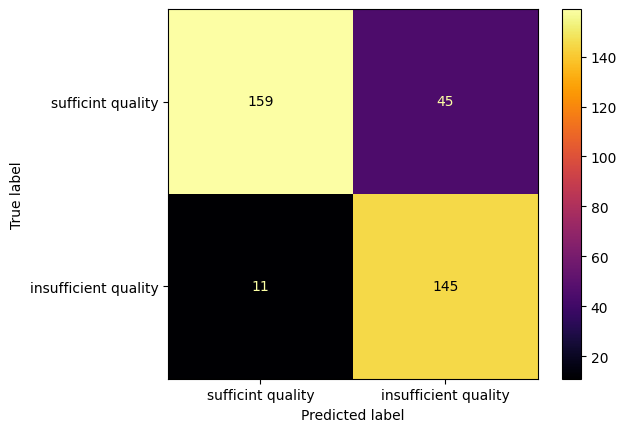

In [35]:
ConfusionMatrixDisplay.from_predictions(true_labels, predictions, display_labels=["sufficint quality", "insufficient quality"], cmap="inferno")

conf_mat = confusion_matrix(true_labels, predictions)

def F1_ind(conf_mat, ind):
    return (2 * conf_mat[ind, ind])/(np.sum(conf_mat[ind]) + np.sum(conf_mat[:, ind]))

print(f"Normal F1: {F1_ind(conf_mat, 0)}")
print(f"Other F1: {F1_ind(conf_mat, 1)}")
# print(f"AF F1: {F1_ind(conf_mat, 2)}")
# print(f"Noisy F1: {F1_ind(conf_mat, 3)}")

print(f"Average F1 score: {sum([F1_ind(conf_mat, i) for i in range(2)])/2}")

In [41]:
index = 40
print(false_positives.shape)

fig = go.Figure(go.Scatter(y=false_positives[index]))
fig.show()

(45, 9000)


In [57]:
index = 15
print(true_negatives.shape)

fig = go.Figure(go.Scatter(y=true_negatives[index]))
fig.show()

(27, 9000)
